# Single Model Training

This notebook is to enable model training for a single model using the specified parameters in config.yaml.


In [137]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.pipelines.xgboost.train_single_model import main

## 1. Run Model

In [138]:
from src.core.models.xgboost import XgboostModel
import pandas as pd


model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_180704/model_0.pickle'
)


feature_importance = pd.read_csv(f"{model.run_directory}/feature_importance.csv")
features_model = list(feature_importance["feature"][0:100].values)
#features = features_model + ["fea_is_gift_driven_event_3m", "feature_gift_driven_avg_sales", "feature_not_gift_driven_avg_sales", "feature_ratio_avg_sales_gift_driven_event_roll_avg_12_months"]
#features = [fea for fea in features if "cultural" not in fea]

drifted_features = [
    "fea_sum_dept_monthly_sales_roll_avg_12_months",
    "fea_dept_std_longevity_months",
    "fea_sum_dept_num_days_item_is_zero_sales",
    "fea_dept_avg_longevity_months",
    "fea_dept_price_avg_roll_avg_12_months",
    "fea_dept_max_days_since_last_sale",
    "fea_sum_cat_monthly_sales_roll_std_12_months",
    "fea_is_national_event_3m",
    "fea_dept_price_std_roll_std_12_months",
    "fea_dept_price_avg_roll_avg_3_months",
    "fea_item_vs_dept_price_ratio_min_roll_max_3_months",
    "fea_item_vs_dept_price_ratio_max_roll_std_12_months",
    "fea_item_vs_dept_price_ratio_min_roll_std_12_months",
    "fea_dept_price_std_roll_std_6_months",
    "fea_dept_price_std_roll_std_3_months",
    "fea_item_monthly_sales_roll_count_12_months",
    "feature_ratio_avg_sales_cultural_event_roll_count_12_months"
]

features = [fea for fea in features_model if fea not in drifted_features]

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_180704/model_0.pickle


In [139]:
# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient
from src.core.config_loader import ConfigLoader

bq_client = BigQueryClient()
config_loader = ConfigLoader()

sales_query = f"""
    SELECT 
    ctx_item_id,
    ctx_date_month,
    ctx_cat_id,
    ctx_dept_id,
    ctx_store_id,
    fea_item_monthly_sales_roll_count_12_months,
    fea_item_monthly_sales_lag_1_months,
    fea_item_monthly_sales_lag_2_months,
    fea_item_monthly_sales_lag_3_months,
    fea_item_monthly_sales_lag_4_months,
    fea_item_monthly_sales_lag_5_months,
    fea_item_monthly_sales_lag_6_months,
    fea_item_monthly_sales_lag_7_months,
    fea_item_monthly_sales_lag_8_months,
    fea_item_monthly_sales_lag_9_months,
    fea_item_monthly_sales_lag_10_months,
    fea_item_monthly_sales_lag_11_months,
    fea_item_monthly_sales_lag_12_months,
    feature_avg_sales_religious_event,
    {','.join(config_loader.inventory_sim_required_fields)},
    {config_loader.target_col},
    {config_loader.benchmark_col},
    {','.join(features)}
    FROM `porygon-pipelines.walmart_training_tables.walmart_master_table` tgt
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND is_stockout_tgt = 0
        AND fea_item_longevity_months >=3
        AND is_stockout_prev_3_m = 0
        AND ctx_cat_id = "HOUSEHOLD"
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 30316 rows from custom query.


In [140]:
features = [fea for fea in df.columns if "fea" in fea]

In [141]:
trained_model = main(features = features, loaded_df=df)
print("last error was 0.12694")

INFO:src.pipelines.xgboost.train_single_model:
        XGBoost Model Training Pipeline is starting...
        
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
INFO:src.pipelines.xgboost.train_single_model:Filtering outliers ...
INFO:src.pipelines.xgboost.train_single_model:Training model...
/Users/anapreciado/Desktop/porygon-demand-forecasting/src/core/transformations/transformations.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loaded_df[target_col] = np.log1p(loaded_df[target_col])
INFO:src.core.models.xgboost:
            Training XGBoost Model...
            


[0]	validation_0-quantile:0.24758	validation_1-quantile:0.25316
[1]	validation_0-quantile:0.19390	validation_1-quantile:0.19863
[2]	validation_0-quantile:0.15916	validation_1-quantile:0.16321
[3]	validation_0-quantile:0.13805	validation_1-quantile:0.14249
[4]	validation_0-quantile:0.12490	validation_1-quantile:0.12998
[5]	validation_0-quantile:0.11674	validation_1-quantile:0.12232
[6]	validation_0-quantile:0.11168	validation_1-quantile:0.11769
[7]	validation_0-quantile:0.10844	validation_1-quantile:0.11514
[8]	validation_0-quantile:0.10636	validation_1-quantile:0.11335
[9]	validation_0-quantile:0.10479	validation_1-quantile:0.11267
[10]	validation_0-quantile:0.10357	validation_1-quantile:0.11215
[11]	validation_0-quantile:0.10252	validation_1-quantile:0.11181
[12]	validation_0-quantile:0.10151	validation_1-quantile:0.11157
[13]	validation_0-quantile:0.10091	validation_1-quantile:0.11147
[14]	validation_0-quantile:0.10015	validation_1-quantile:0.11142
[15]	validation_0-quantile:0.09951	

INFO:src.core.models.xgboost:Model saved to /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_182649/model_0.pickle
INFO:src.core.models.xgboost:
            Model Training Pipeline completed successfully!
            Run ID: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_182649
            Artifacts saved to: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260130_182649
            


last error was 0.12694


In [142]:
# 12799
# 12325

## 2. Compare metrics with Benchmark

1. Compare Metrics (MdAPE, MdAE) with benchmark in total and accross validation sets of interest

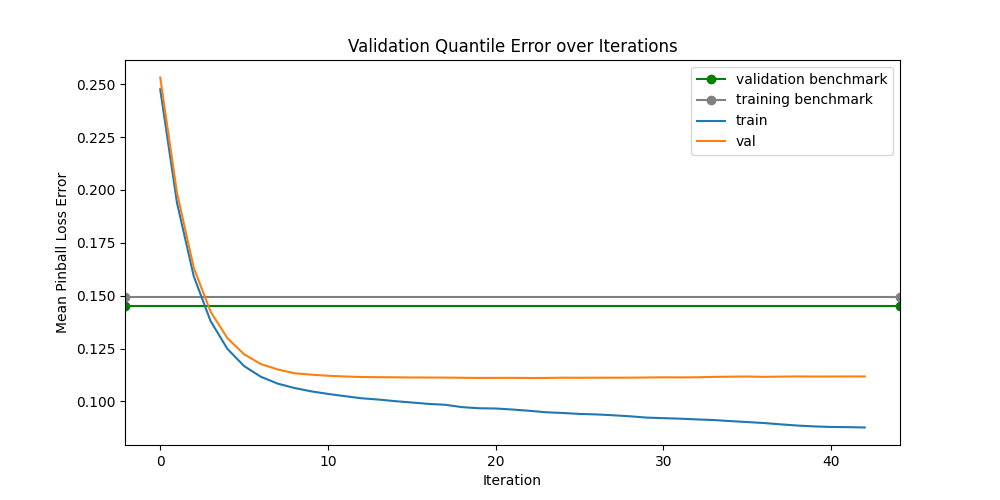

In [143]:
from IPython.display import Image, display
display(Image(trained_model.plot_bias_variance_tradeoff_path))

## 6. Evaluate Residuals

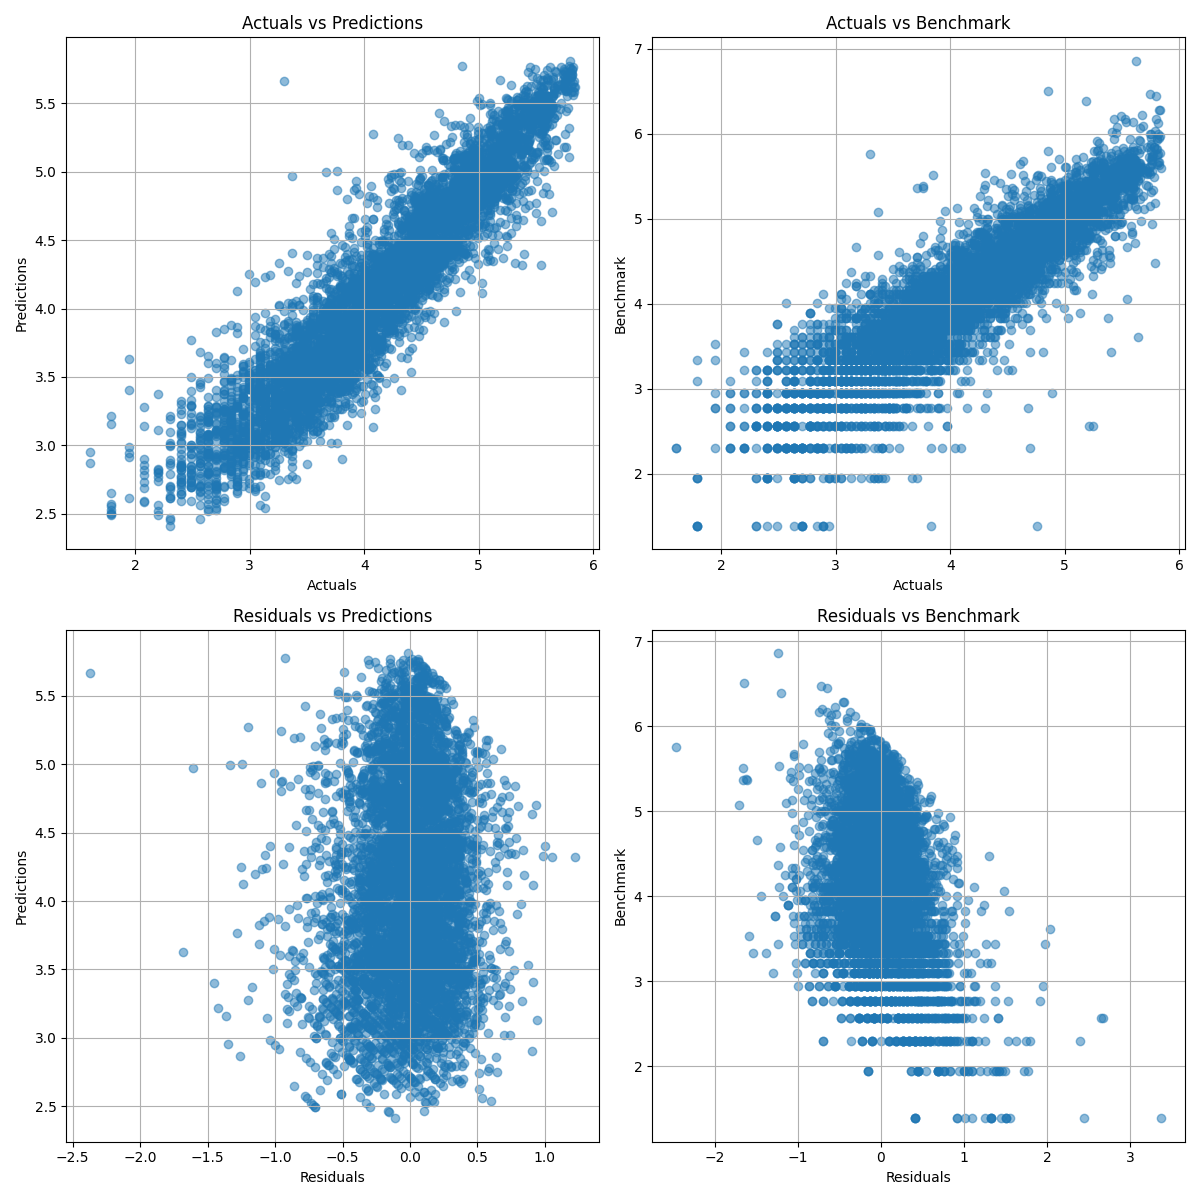

In [144]:
from IPython.display import Image, display
display(Image(trained_model.plot_residuals_paths))

## 8. Feature Importance

In [145]:
trained_model.feature_importance.head(20)

,feature,importance
1,fea_item_monthly_sales_lag_1_months,54.0
17,fea_item_monthly_sales_roll_avg_12_months,51.0
29,fea_item_monthly_sales_roll_coeffvar_12_months,50.0
19,feature_ratio_avg_sales_sport_event_roll_std_1...,49.0
20,feature_ratio_avg_sales_gift_driven_event_roll...,46.0
27,fea_item_vs_dept_price_ratio_avg_roll_std_12_m...,39.0
23,feature_ratio_avg_sales_religious_event_roll_s...,39.0
2,fea_item_monthly_sales_lag_2_months,38.0
34,feature_ratio_avg_sales_snap_ca_roll_max_12_mo...,37.0
33,feature_ratio_avg_sales_snap_ca_roll_avg_12_mo...,36.0


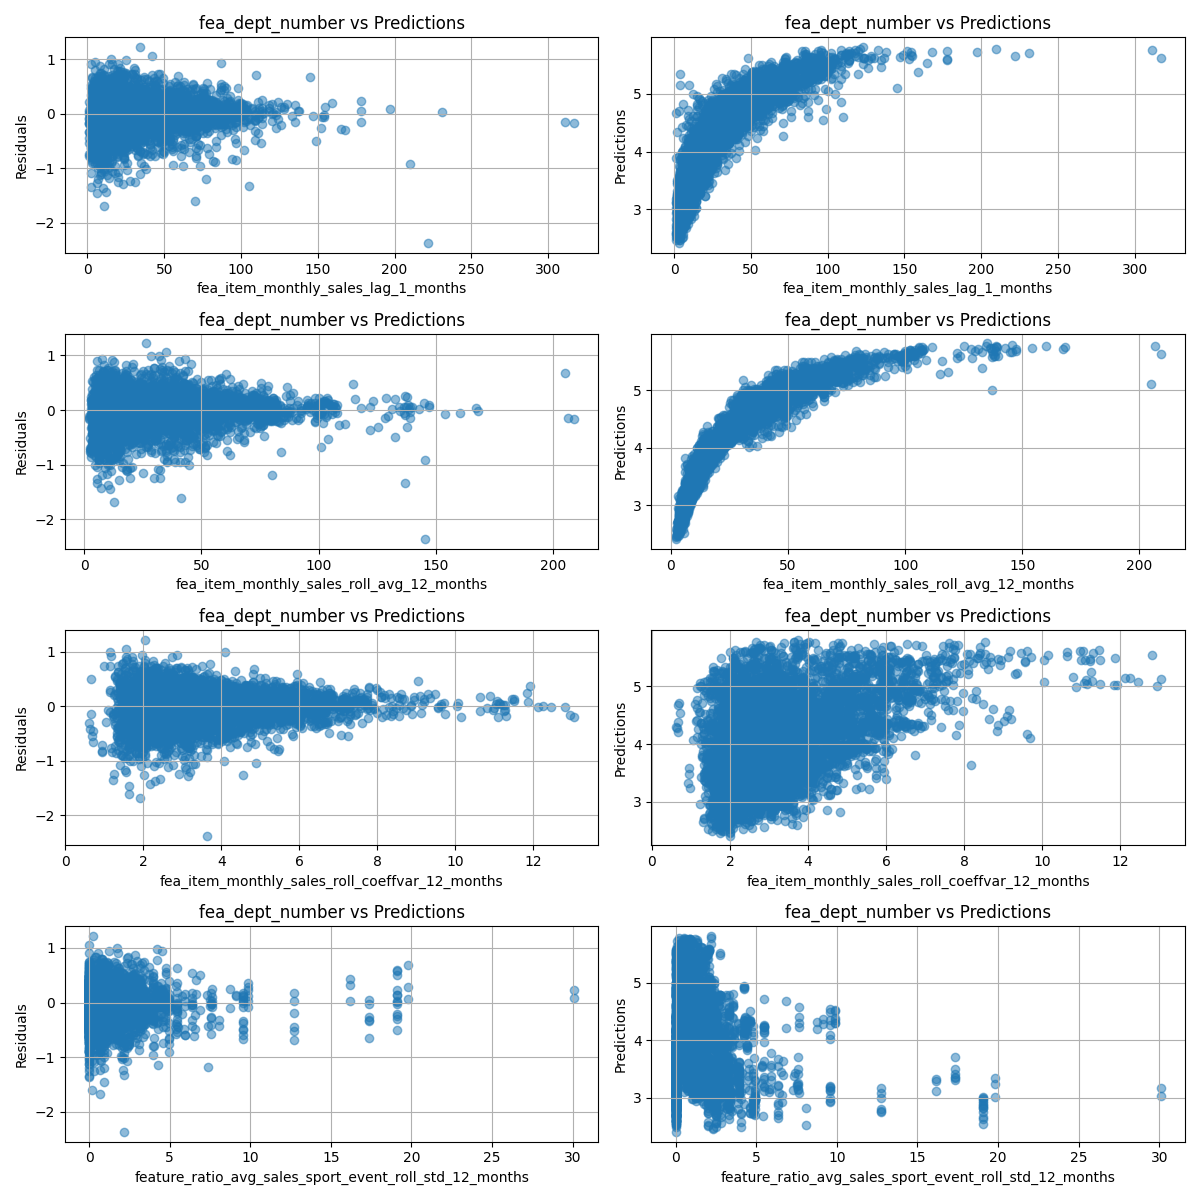

In [146]:
from IPython.display import Image, display
display(Image(trained_model._plot_importance_path))